# Question 8 LBFGS

In [2]:
import numpy as np
from numpy import linalg as LA
import collections
from matplotlib import pyplot as plt

verbosity = False
# Utils

def inverse_sigmoid(var):
    '''
    return 1/(1+exp(var))
    avoid large overflow
    '''
    if var>=0:
        return np.exp(-var)/(1+np.exp(-var))
    else:
        return 1/(1+np.exp(var))

def init_weights(m):
    '''
    Generate random weights in [0,1]
    '''
    return np.random.rand(m, 1)

def logistic_loss_vectorized(w, X, y, la):
    '''
    input: w parameter, X variables, y label, la lambda
    Assignment 6.1
    return f as the loss function value and g as the gradient
    '''
    x_mul_w = np.matmul(X, w)
    y_X_w = np.multiply(y, x_mul_w)
    f = np.sum(np.logaddexp(0, -y_X_w)) + la * np.sum(np.multiply(w,w))
    inv_sigmoid_vector = np.exp(np.minimum(0, -y_X_w))/(1 + np.exp(np.multiply(-y_X_w,np.sign(y_X_w)))) # n * 1
    y_inv_sigmoid = -1 * np.multiply(y, inv_sigmoid_vector)
    g =  np.matmul(y_inv_sigmoid.reshape(1,-1),X) + 2 * la * w.reshape(1,-1)
    g = g.reshape(-1, 1)
    return (f, g)

def hinge_loss_vectorized(w, X, y, la):
    '''
    input: w parameter, X variables, y label, la lambda
    Assignment 6.2
    return f as the loss function value and g as the gradient
    '''
    n = X.shape[0]
    X_cdot_w = np.matmul(X, w)
    one_minus = 1 - np.multiply(X_cdot_w, y)
    f = np.sum(np.maximum(0, one_minus)) + la * np.sum(np.multiply(w,w))
    minus_y = -1 * np.multiply(y, np.double(one_minus>0))
    g = np.matmul(minus_y.reshape(1,-1),X).reshape(-1,1)  + 2 * la *w.reshape(-1,1)
    g = g.reshape(-1,1)
    return (f, g)

# Load data
'''
Copied from https://github.com/rishabhk108/OptimizationML/tree/master/Assignments/data/README.md
'''

from scipy.io import loadmat
import numpy as np
def load_data():
    X = loadmat(r"train.mat")
    y = np.loadtxt(r"train.targets").reshape(-1, 1)
    X = X['X'].todense()
    # print(X.shape)
    # print(y.shape)
    return X,y

def plot(losses, labels):
    fig,ax = plt.subplots()
    for i in range(len(losses)):
        ax.plot(range(1,len(losses[i])+1), losses[i], label=labels[i])
    ax.legend()
    ax.set_xlabel("# Iterations")
    ax.set_ylabel("Loss Function Value")

### LBFGS ###
## Logistic Loss ##
### LBFGS ###
## Hinge Loss ##
### LBFGS ###
## Logistic Loss ##
### LBFGS ###
## Hinge Loss ##


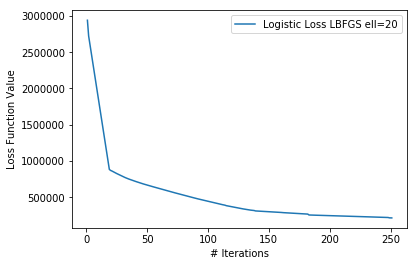

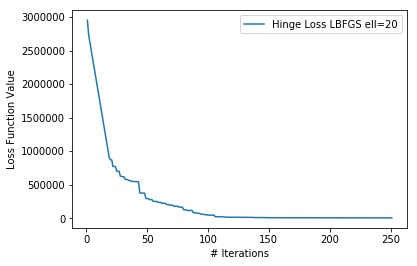

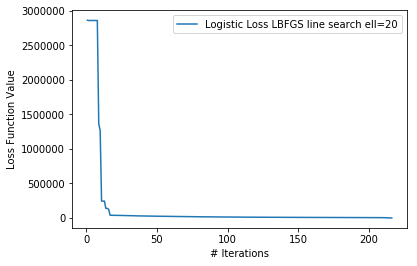

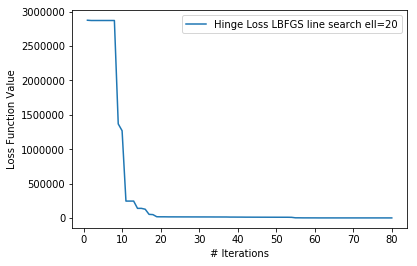

In [7]:
def LBFGS_direction(g_k, S_ell, Y_ell, h):
    '''
    return the gradient descent direction of next step
    s_k = w_{k+1} - w_k
    y_k = g_{k+1} - g_k
    p_k = 1/(y_k^T.s_k)
    H_k = (B_k)^{-1} (inverse of B_k)
    H_{k+1} = (I - s_k.y_k^T)/s_k^T.y_{k}) H_k (I - y_k.s_k^T)/y_k^T.s_k) + s_k.s_k^T/y_k^T.s_k
            = (I - p_k.s_k.y_k^T}) H_k (I - p_k.y_k.s_k^T) + p_k.s_k.s_k^T
    Assuming H_{k}=I
    q_k = g_k
    q_i = (I - p_i.y_i.s_i^T) * q_{i+1}
    a_i = p_i.s_i^T * q_{i+1}
    then q_i = q_{i+1} - a_i.y_i
    beta_i = p_i.y_i^T.z_i
    z_i = H_i.q_i
    '''
    q = g_k
    p = np.zeros(len(S_ell))
    a = np.zeros(len(S_ell))
    Q1 = g_k
    for i in range(len(S_ell)-1, -1, -1):
        p[i] = 1/np.dot(Y_ell[i].T, S_ell[i])[0,0] # p_i = 1/(y_i^T.s_i) # ro ?
        a[i] = p[i] * np.dot(S_ell[i].T, q)[0,0] # a_i = p_i.s_i^T * q_{i+1}
        if i == 0:
            Q1 = q
        q = q - a[i] * Y_ell[i] # q_i = q_{i+1} - a_i.y_i
    # gamma_k = s_{k-1}^T.y_{k-1}/ y_{k-1}^T.y_{k-1} # approximation
    # gamma_k = np.dot(S_ell[-1].T, Y_ell[-1])[0,0]/np.dot(Y_ell[-1].T, Y_ell[-1])[0,0]
    # H_{k-l} = gamma_k * I
    # H_k_0 = gamma_k * np.identity(q.shape[0])
    z = h * Q1
    for i in range(len(S_ell)):
        beta_i = p[i] * np.dot(Y_ell[i].T, z)[0,0] 
        z = z + S_ell[i] * (a[i]-beta_i) # z_{i+1} = z_i + (a_i - beta_i)s_i
    return -z # alpha * -z = s_k

def LBFGS(func_obj, w, max_iter, alpha, X, y, la, gamma, ell):
    f, g = func_obj(w, X, y, la)
    S_ell = collections.deque()
    Y_ell = collections.deque()
    # alpha = alpha / LA.norm(g, 1) # initialize of alpha
    z = -g
    pre_w = w
    pre_f = f
    pre_g = g
    loss = [f, ]
    for cur_iter in range(1, max_iter+1):
        w_tent = w + alpha * z
        f_tent, g_tent = func_obj(w_tent, X, y, la)
        s_k = w_tent - w
        y_k = g_tent - g
        S_ell.append(s_k)
        Y_ell.append(y_k)
        if len(S_ell)>ell:
            S_ell.popleft()
            Y_ell.popleft()
        h = alpha*(np.dot(z.T, Y_ell[-1])[0,0])/(np.dot(Y_ell[-1].T, Y_ell[-1])[0,0]);
        z = LBFGS_direction(g_tent, S_ell, Y_ell, h)
        if verbosity:
            print("Iteration: " + str(cur_iter) + ", alpha = " + str(alpha) +
              ", Loss Function Value = " + str(f_tent))
        pre_f = f
        pre_g = g
        w = w_tent
        g = g_tent
        f = f_tent
        loss.append(f)
    return loss

def LBFGS_line_search(func_obj, w, max_iter, alpha, X, y, la, gamma, ell):
    # verbosity=True
    x = w # x
    f, g = func_obj(x, X, y, la)
    S_ell = collections.deque()
    Y_ell = collections.deque()
    loss = [f,]
    alpha = alpha / LA.norm(g, 1) # initialize of alpha
    z = -g
    cur_iter = 1
    while cur_iter<=max_iter:
        x_tent = x + alpha * z
        f_tent, g_tent = func_obj(x_tent, X, y, la)
        gd = np.dot(g.T, -z)[0,0]
        cur_iter += 1
        backtracking = False
        while f_tent > f - alpha * gamma* gd: # Armijo condition f(w-ag) \le f(w) - alpha * gamma * ||g||^2
            alpha = alpha*alpha*gd /(2*(f_tent + alpha* gd - f))  # Armijo v3 interpolation
            x_tent = x + alpha * z
            loss.append(f)
            f_tent, g_tent = func_obj(x_tent, X, y, la)
            cur_iter += 1
            backtracking = True
        s_k = x_tent - x
        y_k = g_tent - g
        S_ell.append(s_k)
        Y_ell.append(y_k)
        if len(S_ell)>ell:
            S_ell.popleft()
            Y_ell.popleft()
        if verbosity:
            print("Iteration: " + str(cur_iter) + ", alpha = " + str(alpha) +
              ", Loss Function Value = " + str(f_tent))
        h = alpha*(np.dot(z.T, Y_ell[-1])[0,0])/(np.dot(Y_ell[-1].T, Y_ell[-1])[0,0]);
        x = x_tent
        g = g_tent
        f = f_tent
        z = LBFGS_direction(g_tent, S_ell, Y_ell, h)
        if backtracking:
            loss.append(f)
        alpha = 1
    return loss

def test_LBFGS(ell):
    '''
    ell is how many previous step we store
    '''
    X,y = load_data()
    w = init_weights(X.shape[1])
    print('''### LBFGS ###''')
    print('''## Logistic Loss ##''')
    logistic_loss = LBFGS(logistic_loss_vectorized, w, 250, 1e-05, X, y, 1.0, 0.0001, ell)
    print('''### LBFGS ###''')
    print('''## Hinge Loss ##''')
    hinge_loss = LBFGS(hinge_loss_vectorized, w, 250, 1e-05, X, y, 1.0, 0.0001, ell)
    plot([logistic_loss,],['''Logistic Loss LBFGS ell='''+str(ell),])
    plot([hinge_loss,],['''Hinge Loss LBFGS ell='''+str(ell),])
    return [logistic_loss, hinge_loss], '''LBFGS ell30'''+str(ell)
    
def test_LBFGS_line_search(ell):
    '''
    ell is how many previous step we store
    '''
    X,y = load_data()
    w = init_weights(X.shape[1])
    print('''### LBFGS ###''')
    print('''## Logistic Loss ##''')
    logistic_loss = LBFGS_line_search(logistic_loss_vectorized, w, 250, 1, X, y, 1.0, 0.0001, ell)
    print('''### LBFGS ###''')
    print('''## Hinge Loss ##''')
    hinge_loss = LBFGS_line_search(hinge_loss_vectorized, w, 250, 1, X, y, 1.0, 0.0001, ell)
    plot([logistic_loss,],['''Logistic Loss LBFGS line search ell='''+str(ell),])
    plot([hinge_loss,],['''Hinge Loss LBFGS line search ell='''+str(ell),])
    return [logistic_loss, hinge_loss], '''LBFGS ell30'''+str(ell)

func6_res, func6_label = test_LBFGS(20)
func6_res_mod, func6_label_mod = test_LBFGS_line_search(20)